In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import glob
from random import randint
from utils import *
from skimage.feature import hog
from moviepy.editor import VideoFileClip
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import pickle


## Dataset Exploration
Labeled images of vehicles and non-vehicles were obtained from [KITTI vision benchmark suit](http://www.cvlibs.net/datasets/kitti/) and [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html).  
You can download the dataset for vehicles [here](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and non-vehicles [here](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip).  

-----------------------------------------------------------------------------------------------------------------------------------

Total vehicle images = 8792   
Total non-vehicle images = 8968  
Image size = 64 $\times$ 64   

The vehicle images in the database are divided as per the angle in which the images were taken. The images also reflect different lighting condiditons.   
The non-vehicle images consists of roads, trees, traffic signs, pavements or asphalts. 

In [2]:
vehicles_dir = glob.glob("./vehicles/*/*.png", recursive=True)
non_vehicles_dir = glob.glob("./non-vehicles/**/*.png", recursive=True)

print(f"The number of vehicle images = {len(vehicles_dir)}")
print(f"The number of non-vehicle images = {len(non_vehicles_dir)}")

get_img_size(vehicles_dir)
get_img_size(non_vehicles_dir)

The number of vehicle images = 8792
The number of non-vehicle images = 8968
The size of image is 64 by 64
The size of image is 64 by 64
The size of image is 64 by 64
The size of image is 64 by 64


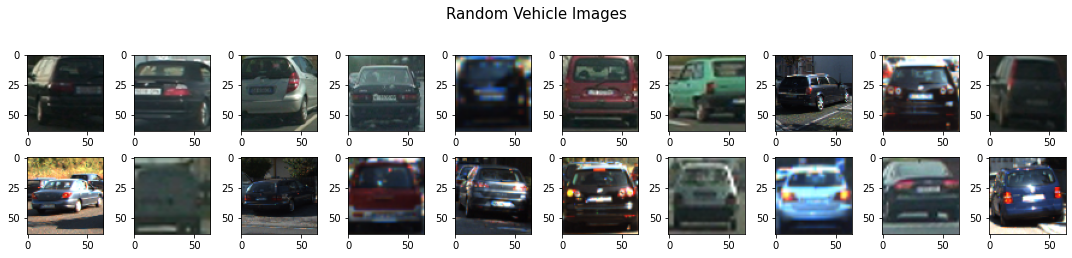

In [17]:

show_random_images(image_dir = vehicles_dir,title = "Random Vehicle Images")

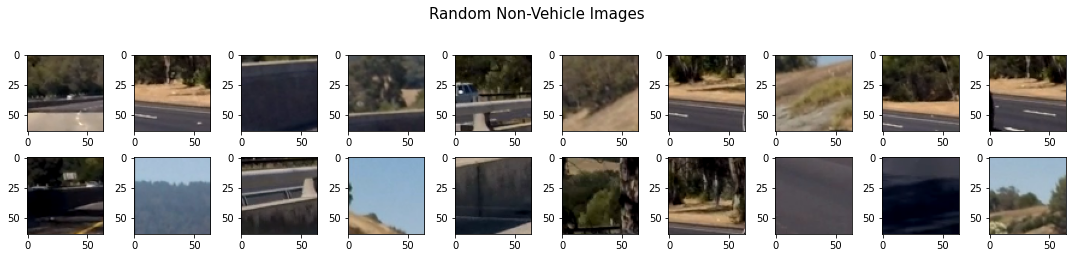

In [18]:
show_random_images(image_dir = non_vehicles_dir,title = "Random Non-Vehicle Images")

## HOG

In [3]:
%run utils.py

# class Arg:
# 	'''
# 	DS to store hog parameters; Used for testing parameter configurations
# 	'''

# 	def __init__(self, color_space, orientation, pix_per_cell, cell_per_block, hog_block_norm = "L2-Hys", color_channel = [0,1,2]):
# 		self.orientation = orientation
# 		self.color_space = color_space
# 		self.pix_per_cell = pix_per_cell
# 		self.cell_per_block = cell_per_block
# 		self.hog_block_norm = hog_block_norm
# 		self.color_channel = color_channel

def image_histogram(image, nbins=32, h_range=(0,256)):
	'''
	to explore color histogram across the 3 color channel
	bins: defines the number of equal-width bins in a range
	range: since the images are RGB range is set to (0,256)
	Comptes the histogram of color across the three channels nad returns a concatenated feature vector
	'''

	channel0 = np.histogram(image[:,:,0], bins = nbins, range = h_range)
	channel1 = np.histogram(image[:,:,1],  bins = nbins, range = h_range)
	channel2 = np.histogram(image[:,:,2],  bins = nbins, range = h_range)
	hist_color = np.concatenate((channel0[0], channel1[0], channel2[0]))
	return hist_color

def hog_features(image, orientation, pix_per_cell, cell_per_block, vis = True, feature_vec = True, norm = "L2-Hys" ):

	'''
	Computes the histogram of oriented gradients. 

	Returns: features vector, corresponding hog image (hog_image)
	
	'''
	features, hog_image = hog(image, 
								orientations = orientation,  
								pixels_per_cell = (pix_per_cell,pix_per_cell), 
								cells_per_block = (cell_per_block,cell_per_block), 
								transform_sqrt = False, 
								visualize = vis, 
								feature_vector = feature_vec, 
								block_norm = norm
							)

	return features, hog_image

def get_all_features(img_dir, arguments):
	features = []
	# if len(img_dir) == 1:
	for im in img_dir:
		image = plt.imread(im)
		
		feature_image = change_color_space(image, arguments.color_space)

		f = []
		for i in arguments.color_channel:
			channel_feature, channel_image = hog_features(feature_image[:,:,i], orientation = arguments.orientation, pix_per_cell = arguments.pix_per_cell, cell_per_block = arguments.cell_per_block)
			f.append(channel_feature)
		f = np.ravel(f)

		spatial_features = resize_image(feature_image, size=(32,32))
		hist_features = image_histogram(feature_image)


		features.append(np.concatenate((spatial_features, hist_features,f)))
	return features


### Choosing sutiable hog parameters
###### Tested on the original color scale (`RGB`) by varying `orientations`, `pixels_per_cell`, `cells_per_block`

In [4]:
class Parameters:
	'''
	DS to store hog parameters; Used for testing parameter configurations
	'''

	def __init__(self, color_space, orientation, pix_per_cell, cell_per_block, hog_block_norm = "L2-Hys", color_channel = [0,1,2]):
		self.orientation = orientation
		self.color_space = color_space
		self.pix_per_cell = pix_per_cell
		self.cell_per_block = cell_per_block
		self.hog_block_norm = hog_block_norm
		self.color_channel = color_channel


def get_hog_features_for_parameter_set(img_dir, param_set):
	'''
	For testing different hog configurations
	Takes image and parameter set and returns a multi dimensional array such that a[i] = [image, channel1HogImage, channel2HogImage, channel3HogImage, hogParameters]
	'''
	features_set = []
	img = plt.imread(img_dir)
	
	for p in param_set:
		label = f"o = {p.orientation}, px/c = {p.pix_per_cell}, c/b = {p.cell_per_block}"
		hog_viz = []
		cspace_image = change_color_space(img, p.color_space)
		for channel in p.color_channel:
			f, viz = hog_features(cspace_image[:,:,channel], orientation = p.orientation, pix_per_cell = p.pix_per_cell, 
									cell_per_block = p.cell_per_block)
			hog_viz.append(viz)
		
		features_set.append([cspace_image, hog_viz[0], hog_viz[1], hog_viz[2], label])
	return features_set

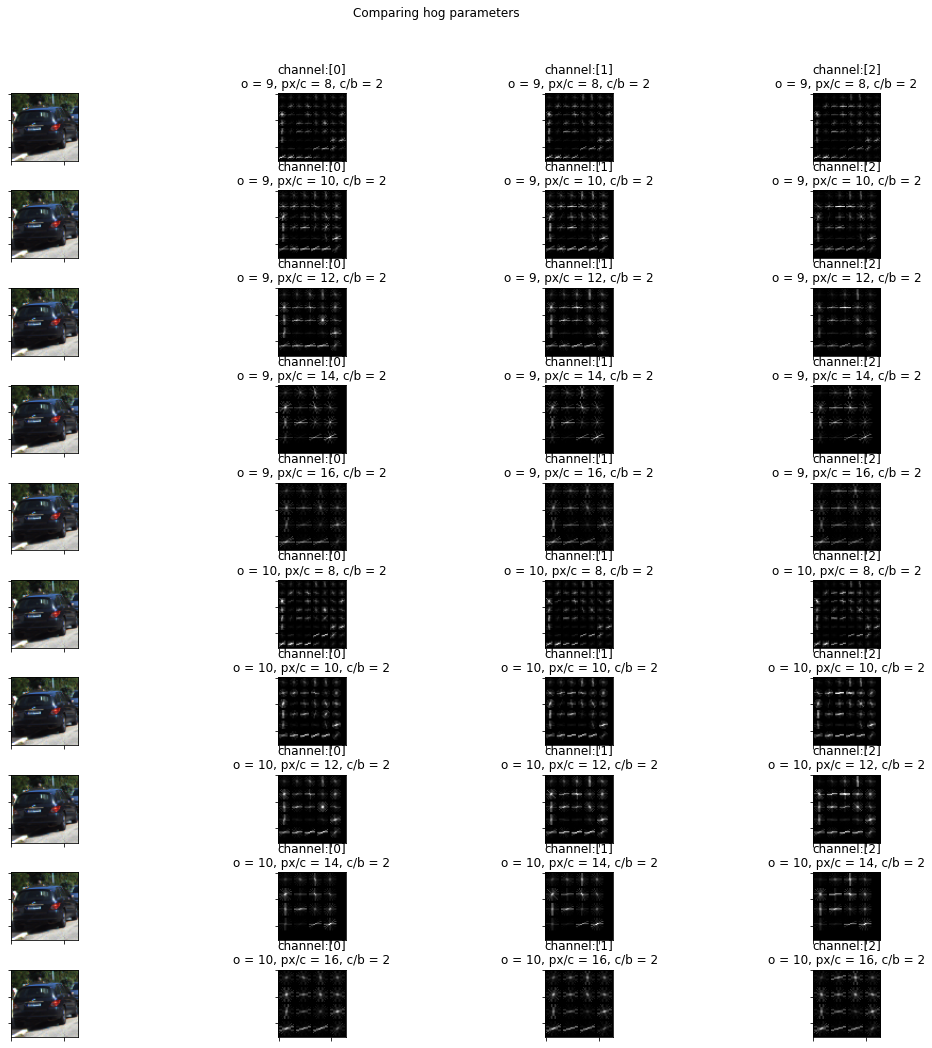

In [21]:
%run utils.py
test_set = [Parameters("RGB", 9, 8, 2),
	Parameters("RGB", 9, 10, 2),
	Parameters("RGB", 9, 12, 2),
	Parameters("RGB", 9, 14, 2),
	Parameters("RGB", 9, 16, 2),
	Parameters("RGB", 10, 8, 2),
	Parameters("RGB", 10, 10, 2),
	Parameters("RGB", 10, 12, 2),
	Parameters("RGB", 10, 14, 2),
	Parameters("RGB", 10, 16, 2)]

test_vehcle_image = vehicles_dir[randint(0,8000)]
feature_set = get_hog_features_for_parameter_set(img_dir= test_vehcle_image, param_set = test_set)
feature_set_viz(feature_set, title = "Comparing hog parameters ")




10-10-2
9-10-2

In [7]:
actual = Parameters("YCrCb", 9,8,2)

vehicles_features = get_all_features(vehicles_dir, actual)
non_vehicles_features = get_all_features(non_vehicles_dir, actual)

In [13]:
actual = Parameters("RGB", 11,14,2)
print(actual.__dict__)

{'orientation': 11, 'color_space': 'RGB', 'pix_per_cell': 14, 'cell_per_block': 2, 'hog_block_norm': 'L2-Hys', 'color_channel': [0, 1, 2]}


In [56]:
#### Need to get featurs for the following configurations

shorltilst_parameter = [Parameters("YCrCb", 10,10,2),
						Parameters("YCrCb", 9,10,2), 
						Parameters("YCrCb", 9,8,2),
						Parameters("YCrCb", 15,9,2),]

for p in shorltilst_parameter:
	file_name = f"{p.color_space}_{p.orientation}_{p.pix_per_cell}_{p.cell_per_block}.p"
	
	vehicles_features = get_all_features(vehicles_dir, p)
	non_vehicles_features = get_all_features(non_vehicles_dir, p)

	
	feat = {}
	feat["vehicles"] = vehicles_features
	feat["non-vehicles"] = non_vehicles_features
	pickle.dump(feat, open(f"./configurations/{file_name}", 'wb') )




In [16]:
import pickle
feat = {}
feat["vehicles"] = vehicles_features
feat["non-vehicles"] = non_vehicles_features
pickle.dump(feat, open(f"./configurations/test.p", 'wb') )

In [7]:
import pickle
config_dir = glob.glob("D:/")
dist_pickle = pickle.load( open("./configurations/test.p", "rb" ) )
vec_fe = dist_pickle["vehicles"]
nv_fec = dist_pickle["non-vehicles"]

In [6]:
import pickle
import pandas as pd
config_dir = glob.glob("D:/config/*.p")
print(config_dir)
config_dir.remove('D:/config\\HSV_15_9_2.p')
final = {}
for conf in config_dir:
	dist_pickle = pickle.load( open(conf, "rb" ) )
	vec_fe = dist_pickle["vehicles"]
	nv_fec = dist_pickle["non-vehicles"]

	X = np.vstack((vec_fe, nv_fec)).astype(np.float64)        
               

	X_scaler = StandardScaler().fit(X)
	scaled_X = X_scaler.transform(X)


	y = np.hstack((np.ones(len(vec_fe)), np.zeros(len(nv_fec))))

	# Split up data into randomized training and test sets
	X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)


	# Use a linear SVC 
	svc = LinearSVC()

	# Check the training time for the SVC
	t=time.time()
	svc.fit(X_train, y_train)
	t2 = time.time()

	diff = t2-t
	accuracy = round(svc.score(X_test, y_test), 4)
	print(f"accuracy for : {conf} = {accuracy}")
	final[conf] = accuracy



['D:/config\\HLS_10_10_2.p', 'D:/config\\HLS_15_9_2.p', 'D:/config\\HLS_9_10_2.p', 'D:/config\\HLS_9_8_2.p', 'D:/config\\HSV_10_10_2.p', 'D:/config\\HSV_15_9_2.p', 'D:/config\\HSV_9_10_2.p', 'D:/config\\HSV_9_8_2.p', 'D:/config\\LUV_10_10_2.p', 'D:/config\\LUV_15_9_2.p', 'D:/config\\LUV_9_10_2.p', 'D:/config\\LUV_9_8_2.p', 'D:/config\\RGB_10_10_2.p', 'D:/config\\RGB_11_14_2.p.p', 'D:/config\\RGB_15_9_2.p', 'D:/config\\RGB_9_10_2.p', 'D:/config\\RGB_9_8_2.p', 'D:/config\\YCrCb_10_10_2.p', 'D:/config\\YCrCb_15_9_2.p', 'D:/config\\YCrCb_9_10_2.p', 'D:/config\\YCrCb_9_8_2.p', 'D:/config\\YUV_10_10_2.p', 'D:/config\\YUV_15_9_2.p', 'D:/config\\YUV_9_10_2.p', 'D:/config\\YUV_9_8_2.p']
accuracy for : D:/config\HLS_10_10_2.p = 0.9899
accuracy for : D:/config\HLS_15_9_2.p = 0.9916
accuracy for : D:/config\HLS_9_10_2.p = 0.9879
accuracy for : D:/config\HLS_9_8_2.p = 0.993
accuracy for : D:/config\HSV_10_10_2.p = 0.9924
accuracy for : D:/config\HSV_9_10_2.p = 0.9918
accuracy for : D:/config\HSV_9_

In [18]:
print(final.items())
arr = np.array(final.items())
df = pd.DataFrame(arr, columns=("conf", 'acc'))
df

dict_items([('D:/config\\HLS_10_10_2.p', 0.9899), ('D:/config\\HLS_15_9_2.p', 0.9916), ('D:/config\\HLS_9_10_2.p', 0.9879), ('D:/config\\HLS_9_8_2.p', 0.993), ('D:/config\\HSV_10_10_2.p', 0.9924), ('D:/config\\HSV_9_10_2.p', 0.9918), ('D:/config\\HSV_9_8_2.p', 0.9932), ('D:/config\\LUV_10_10_2.p', 0.9873), ('D:/config\\LUV_15_9_2.p', 0.9876), ('D:/config\\LUV_9_10_2.p', 0.9856), ('D:/config\\LUV_9_8_2.p', 0.9899), ('D:/config\\RGB_10_10_2.p', 0.9865), ('D:/config\\RGB_11_14_2.p.p', 0.9783), ('D:/config\\RGB_15_9_2.p', 0.9823), ('D:/config\\RGB_9_10_2.p', 0.9823), ('D:/config\\RGB_9_8_2.p', 0.9834), ('D:/config\\YCrCb_10_10_2.p', 0.9896), ('D:/config\\YCrCb_15_9_2.p', 0.989), ('D:/config\\YCrCb_9_10_2.p', 0.9899), ('D:/config\\YCrCb_9_8_2.p', 0.9899), ('D:/config\\YUV_10_10_2.p', 0.9885), ('D:/config\\YUV_15_9_2.p', 0.9876), ('D:/config\\YUV_9_10_2.p', 0.9851), ('D:/config\\YUV_9_8_2.p', 0.9907)])


ValueError: Must pass 2-d input. shape=()

### Sliding Window search

In [27]:
def search_cars(image_dir, model, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, h_bins, y_startstop_scale, h_shift = 0 , vis = False):
	box_detection_list = []
	box_vis_list = []

	#normalize image
	img = plt.imread(image_dir)
	# img = image_dir
	img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)	
	img = img.astype(np.float64)/255

	for (ystart, ystop, scale) in y_startstop_scale:
		box = []
		img_search = img[ystart:ystop, :, :]  #cropping image
		if scale != 1:
			imshape = img_search.shape
			img_search = cv2.resize(img_search, (int(imshape[1]/scale), int(imshape[0]/scale)))
		
		channel0 = img_search[:,:,0]
		c0hog, c0img = hog_features(channel0, orient, pix_per_cell, cell_per_block, feature_vec=False)

		channel1 = img_search[:,:,1]
		c1hog, c1img = hog_features(channel1, orient, pix_per_cell, cell_per_block, feature_vec=False)

		channel2 = img_search[:,:,2]
		c2hog, c2img = hog_features(channel2, orient, pix_per_cell, cell_per_block, feature_vec=False)
	

		#defining blocks
		crop_image_shape = img_search.shape
		xblock =  int(crop_image_shape[1]/pix_per_cell)- cell_per_block + 3
		yblock = int(crop_image_shape[0]/ pix_per_cell)- cell_per_block + 1
		features_per_block = orient*(cell_per_block**2)

		## window
		window = 64
		next_step = 2 # how many cells to step
		blocks_per_window = int(window/pix_per_cell)-cell_per_block + 1
		xstep = int((xblock - blocks_per_window)/next_step)
		ystep = int((yblock - blocks_per_window)/next_step)


		for x in range(xstep):
			for y in range(ystep):
				y_pos = y * next_step
				x_pos = x * next_step
				x_left = x_pos*pix_per_cell
				y_top = y_pos*pix_per_cell

				

				h0 = c0hog[y_pos:y_pos+blocks_per_window, x_pos:x_pos+blocks_per_window].ravel()
				h1 = c1hog[y_pos:y_pos+blocks_per_window, x_pos:x_pos+blocks_per_window].ravel()
				h2 = c2hog[y_pos:y_pos+blocks_per_window, x_pos:x_pos+blocks_per_window].ravel()
				h = np.hstack((h0, h1, h2))
				subimg = cv2.resize(img_search[y_top:y_top+window, x_left:x_left+window], (64,64))
				spatial_f = resize_image(subimg, size = spatial_size)
				hist_f = image_histogram(subimg, nbins=h_bins)
				final_f = np.hstack((spatial_f, hist_f, h)).reshape(1,-1)

				test_f = X_scaler.transform(final_f)

				prediction = model.predict(test_f)

				x_box_left = int(x_left*scale)
				y_box_top = int(y_top*scale)
				win = int(window*scale)
				pos = ((x_box_left, y_box_top+ystart),(x_box_left+win,y_box_top+win+ystart))

				if vis == True:
					# x_box_left = int(x_left*scale)
					# y_box_top = int(y_top*scale)
					# win = int(window*scale)
					# pos = ((x_box_left+h_shift, y_box_top+ystart),(x_box_left+win,y_box_top+win+ystart))

					box.append(pos)
					
				

				if prediction == 1:
					# x_box_left = int(x_left*scale)
					# y_box_top = int(y_top*scale)
					# win = int(window*scale)
					# pos = ((x_box_left+h_shift, y_box_top+ystart),(x_box_left+win+h_shift,y_box_top+win+ystart))

					box_detection_list.append(pos)
					cv2.rectangle(img, (x_box_left, y_box_top+ystart), (x_box_left+win,y_box_top+win+ystart), (0,255,0),6)
		box_vis_list+= [box]
		
	return box_detection_list, img, box_vis_list
					





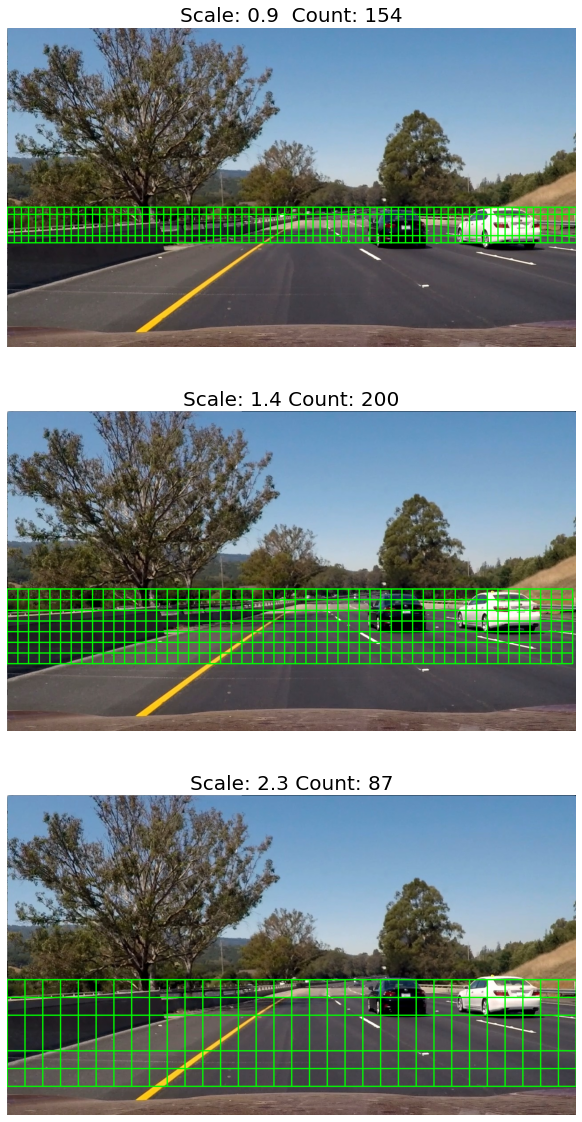

In [52]:
spatial = 32
hist_bins = 32
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb #YCrCb best
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size= (32, 32)
heat_threshold= 4 # 12
hog_channel = [0,1,2] # Can be 0, 1, 2, or "ALL" #ALL,0 best
ystart_ystop_scale = [(405, 510, 1), (400, 600, 1.5), (500, 710, 2.5)]

test_images = "./test_images/test6.jpg"
i = plt.imread(test_images)


ystart_ystop_scale = [(405, 510, 1), (400, 600, 1.5), (415, 710, 2.5)]
bbox_detection_list, detections, box_vis_list = search_cars(test_images, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, ystart_ystop_scale, vis=True)

def draw_boxes(img, bboxes):
    imcopy = [np.copy(img),np.copy(img),np.copy(img)]

    for i in range(len(bboxes)):
        for bbox in bboxes[i]:
            cv2.rectangle(img=imcopy[i], pt1=bbox[0], pt2=bbox[1],
                          color=(0,255,0), thickness=2)
    return imcopy

windows_img = draw_boxes(i, box_vis_list)

f, ((ax1, ax2, ax3)) = plt.subplots(3, 1, figsize=(20,20))
ax1.imshow(windows_img[0])
title = "Scale: 0.9 "  + " Count: " + str(len(box_vis_list[0])) 
ax1.set_title(title, fontsize=20)
ax1.axis("off")
ax2.imshow(windows_img[1])
title = "Scale: 1.4"  + " Count: " + str(len(box_vis_list[1])) 
ax2.set_title(title, fontsize=20)
ax2.axis("off")
ax3.imshow(windows_img[2])
title = "Scale: 2.3"  + " Count: " + str(len(box_vis_list[2])) 
ax3.set_title(title, fontsize=20)
ax3.axis("off")

plt.show()


(-0.5, 1279.5, 719.5, -0.5)

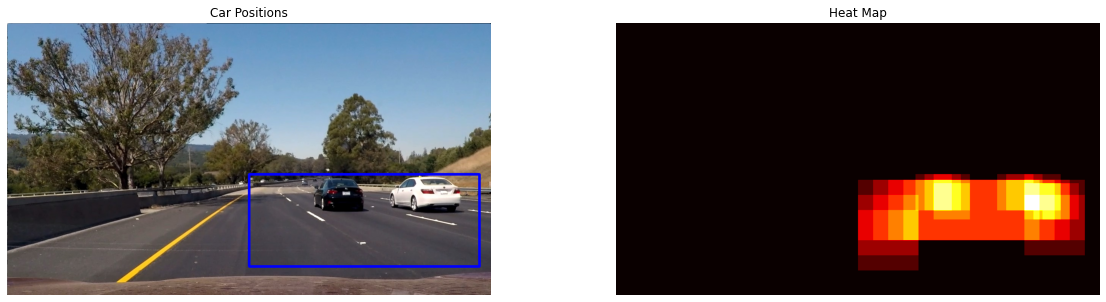

In [53]:
im = "./test_images/test6.jpg"
i = plt.imread(im)
blank = np.zeros_like(i[:,:,0]).astype(np.float64)

def add_heat(heatmap, box_list):
	for box in box_list:
		heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
	return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], (bbox[1][0]+10,bbox[1][1]-10), (0,0,255), 6)
    # Return the image
    return img


# Using Subsampled HOG windows to get possible detections 
bbox_detection_list, detections, box_vis_list = search_cars(im, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,ystart_ystop_scale)

# Add heat to each box in box list
heatmap = add_heat(blank, bbox_detection_list)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(i), labels)

fig = plt.figure(figsize = (20,5))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.axis('off')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.axis('off')

(-0.5, 1279.5, 719.5, -0.5)

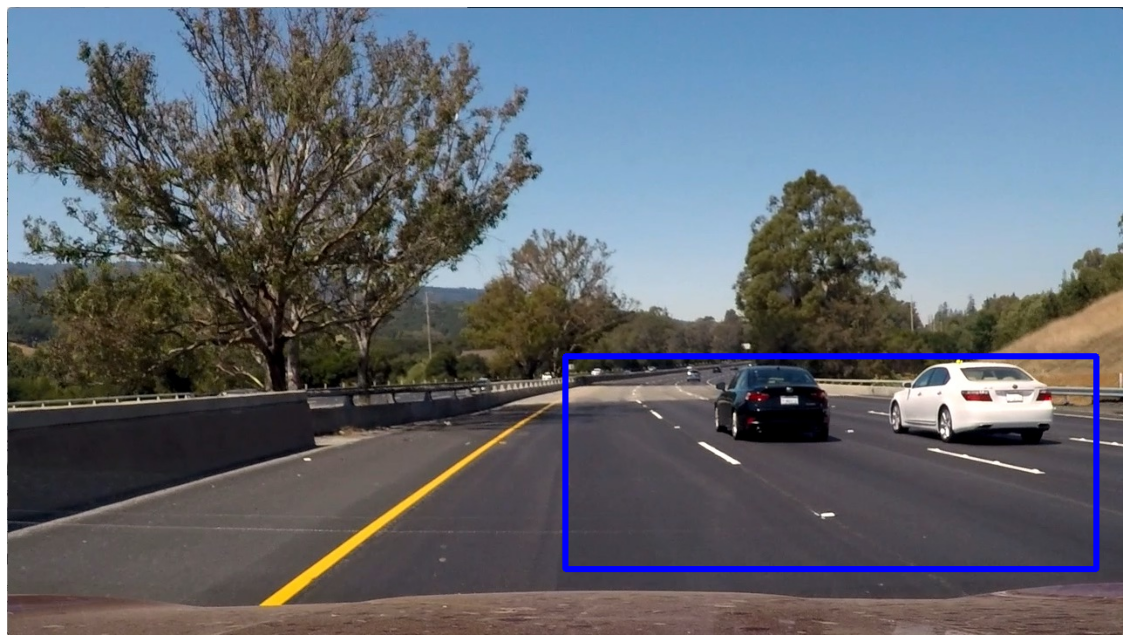

In [54]:
# Accumulation of labels from last N frames
class Detect_history():
    def __init__ (self):
        # Number labels to store
        self.queue_len = 7 #17 13
        self.queue = []

    # Put new frame
    def put_labels(self, labels):
        if (len(self.queue) > self.queue_len):
            tmp = self.queue.pop(0)
        self.queue.append(labels)
    
    # Get last N frames hot boxes
    def get_labels(self):
        detections = []
        for label in self.queue:
            detections.extend(label)
        return detections

### Parameters

def process_image(img): 
    i = plt.imread(img)
    
    # Using Subsampled HOG windows to get possible detections 
    bbox_detection_list, detections, box_vis_list = search_cars(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,ystart_ystop_scale)

    blank = np.zeros_like(i[:,:,0]).astype(np.float)

    # Smoothing out previous detections
    detect_history.put_labels(bbox_detection_list)
    bbox_detection_list = detect_history.get_labels()

    # Add heat to detections
    heatmap = add_heat(blank, bbox_detection_list)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)

    # Draw bounding box 
    result = draw_labeled_bboxes(np.copy(i), labels)
    
    return result


detect_history = Detect_history()
x = "./test_images/test6.jpg"
result = process_image(x)
plt.figure(figsize = (20,20))
plt.imshow(result)
plt.axis("off")

In [55]:
%run utils.py
detect_history = Detect_history()
project_video_res = 'project_video_result.mp4'
clip1 = VideoFileClip("./test_images/project_video.mp4")
project_video_clip = clip1.fl_image(process_image("./test_images/test6.jpg"))
project_video_clip.write_videofile(project_video_res, audio=False)

TypeError: 'numpy.ndarray' object is not callable

<Figure size 432x288 with 0 Axes>